Logistic Regression for Churn Prediction

To begin the modeling phase, we start with Logistic Regression, a widely used and interpretable algorithm for binary classification tasks.

Since our goal is to predict whether a customer will churn (Yes/No), logistic regression is well-suited as it estimates the probability of a binary outcome. It also helps us understand the influence of individual features on churn, making it valuable not just for prediction but also for gaining insights into customer behavior.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay 
from sklearn.utils import resample 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import pickle 

In this section, we import all the necessary Python libraries and modules needed to build, evaluate, and visualize our machine learning model.

We use pandas and numpy for data handling and numerical operations. For modeling, we use logistic regression from scikit-learn, along with tools for splitting the data, performing cross-validation, and tuning hyperparameters.

To evaluate model performance, we import metrics such as the classification report, ROC AUC score, recall, and confusion matrix visualizers. We also use a standard scaler to normalize numerical features, which helps improve model performance. Lastly, matplotlib is used for visualizing results, and pickle is included in case we want to save the trained model for future use

In [3]:
reg_model = pd.read_csv('telecom_net_churn.csv')
reg_model.head()

,Unnamed: 0,SeniorCitizen,MonthlyCharges,TotalCharges,Churn_Values,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_Grouped_1 - 12,Tenure_Grouped_13 - 24,Tenure_Grouped_25 - 36,Tenure_Grouped_37 - 48,Tenure_Grouped_49 - 60,Tenure_Grouped_61 - 72
0,0,0,29,29,0,1,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
1,1,0,56,1889,0,0,1,1,0,1,...,0,0,0,1,0,0,1,0,0,0
2,2,0,53,108,1,0,1,1,0,1,...,0,0,0,1,1,0,0,0,0,0
3,3,0,42,1840,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,4,0,70,151,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


We load the cleaned and preprocessed dataset telecom_net_churn.csv, which was saved after completing the exploratory data analysis and feature engineering steps. This dataset includes all the necessary transformations such as one-hot encoding, numerical conversions, and the Churn_Values column that serves as our target variable. It is now ready to be used for training machine learning models

In [4]:
reg_model['Churn_Values'].value_counts()

Churn_Values
0    5163
1    1869
Name: count, dtype: int64

We examine the distribution of the target variable Churn_Values. There are 5,163 customers who did not churn (label 0) and 1,869 customers who did churn (label 1). This indicates a class imbalance, with significantly more non-churners than churners. Addressing this imbalance will be important for building a fair and effective classification model.

In [5]:
df_majority = reg_model[reg_model['Churn_Values'] == 0]
df_minority = reg_model[reg_model['Churn_Values'] == 1]

To address the class imbalance in our target variable, we first separate the dataset into two groups: one containing the majority class (customers who did not churn) and the other containing the minority class (customers who did churn). This separation allows us to apply resampling techniques to balance the dataset before training the model.

In [6]:
# checking shape 
print(df_majority.shape)
print(df_minority.shape)

(5163, 52)
(1869, 52)


We check the number of records in each class to confirm the imbalance. This helps guide the next step of resampling the minority class.

In [7]:
df_minority_upsampled = resample(df_minority,
replace = True,
n_samples = len(df_majority),
random_state = 42
)

df_upsampled = pd.concat([df_majority,df_minority_upsampled])
df_upsampled = df_upsampled.sample(frac = 1,random_state = 42).reset_index(drop = True)

To address the class imbalance, we apply upsampling to the minority class (churned customers). This involves randomly duplicating samples from the minority class until it matches the number of majority class records. We then combine the upsampled minority data with the majority class and shuffle the dataset to ensure a balanced and unbiased training set

In [8]:
df_upsampled.shape

(10326, 52)

We check the shape of the upsampled dataset to ensure that both classes are now balanced and ready for model training

In [9]:
df_upsampled['Churn_Values'].value_counts()

Churn_Values
0    5163
1    5163
Name: count, dtype: int64

We confirm that the upsampled dataset now has an equal number of churned and non-churned customers, with 5,163 records in each class. This balanced distribution helps improve model fairness and performance.

In [10]:
x = df_upsampled.drop(columns =['Unnamed: 0','Churn_Values'])
y = df_upsampled['Churn_Values']

We separate the dataset into input features (x) and the target variable (y). The feature set includes all columns except Churn_Values and Unnamed: 0, which is just an index column from the saved CSV. This step prepares the data for training a machine learning model

In [11]:
x_temp,x_test,y_temp,y_test = train_test_split(x,y,test_size = 0.15,random_state = 42)

x_train,x_val,y_train,y_val = train_test_split(x_temp,y_temp,test_size = 0.2,random_state = 42)


In [ ]:
# review of the split data 
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(7021, 50)
(1756, 50)
(1549, 50)


We divide the dataset into three subsets to ensure proper model development and evaluation. First, 15 percent of the data is reserved as the test set, which will be used to assess final model performance. The remaining data is further split, with 20 percent allocated to a validation set. This validation set allows us to fine-tune the model and monitor its performance during training before making predictions on the test set. This approach helps prevent overfitting and supports better generalization to unseen data

In [13]:
# combine x and y for saving
train_df = pd.concat([x_train,y_train],axis = 1)
validation_df = pd.concat([x_val,y_val],axis = 1)
test_df = pd.concat([x_test,y_test],axis = 1)

# saving data 

train_df.to_csv('train_data.csv',index = False)
validation_df.to_csv('validation_data.csv',index = False)
test_df.to_csv('test_data.csv',index = False)



In [14]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

Before training the model, we apply feature scaling to standardize the input features. This ensures that all features contribute equally to the model and are on the same scale. We use StandardScaler to transform the training, validation, and test sets by centering them around the mean with unit variance.

In [15]:
log_model = LogisticRegression(max_iter = 1000)
log_model.fit(x_train_scaled,y_train)

LogisticRegression(max_iter=1000)

We now train a basic logistic regression model using the scaled training data. Logistic regression is a linear model suitable for binary classification tasks like predicting customer churn. We set the maximum number of iterations to 1000 to ensure the model has enough iterations to converge during training. This trained model will be used to make predictions and evaluate performance on the validation and test sets

In [16]:
## Cross-validation on scaled training data

cv_auc = cross_val_score(log_model, x_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Cross-Validated AUC:", cv_auc.mean())

Cross-Validated AUC: 0.8444826849180813


To assess the model’s consistency and generalization ability, we perform 5-fold cross-validation on the scaled training data. We use the ROC AUC score as the evaluation metric, which measures the model’s ability to distinguish between churned and non-churned customers across different thresholds.

The result is a cross-validated AUC score of 0.844, which indicates good model performance. This means that, on average, the model can correctly rank a randomly chosen churned customer higher than a randomly chosen non-churned customer about 84.4 percent of the time. This is a strong indicator that the model is effectively learning the underlying patterns in the data.

In [17]:
#Evaluate on Validation Set

y_val_pred = log_model.predict(x_val_scaled)
y_val_prob = log_model.predict_proba(x_val_scaled)[:,1]

print('Validation Accuracy:',log_model.score(x_val_scaled,y_val))
print('Validation Recall:',recall_score(y_val,y_val_pred))
print('Validation ROC AUC',roc_auc_score(y_val,y_val_prob))
print('Classification Report:\n',classification_report(y_val,y_val_pred))


Validation Accuracy: 0.7585421412300684
Validation Recall: 0.7951945080091534
Validation ROC AUC 0.8422343384340769
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75       882
           1       0.74      0.80      0.77       874

    accuracy                           0.76      1756
   macro avg       0.76      0.76      0.76      1756
weighted avg       0.76      0.76      0.76      1756



The validation set plays a crucial role in the model development process. It allows us to evaluate the model’s performance on unseen data before testing it on the final test set.

The logistic regression model shows strong performance on the validation set:

- The model achieved 76% accuracy, meaning it correctly predicted the churn outcome for three out of every four customers.

- It demonstrated a recall of 80% for churned customers, which is especially important in churn prediction where identifying customers likely to leave is critical for proactive retention.

- The ROC AUC score of 0.84 indicates very good discriminatory power — the model effectively distinguishes between churned and non-churned customers across different threshold levels.

- The classification report shows balanced performance across both classes, with solid precision and F1-scores.

In [18]:
#Tune logistic Regression with GridSearchCV 

param_grid = {'C':[0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(max_iter = 1000),param_grid,scoring = 'roc_auc',cv = 5)
grid.fit(x_train_scaled,y_train)
print('Best CV ROC AUC:',grid.best_score_)

Best CV ROC AUC: 0.84482924871636


We tuned the logistic regression model using GridSearchCV to find the best regularization strength (C). After testing different values, the best ROC AUC score reached 0.8448, slightly better than our original model. This improvement may seem small, but in a sensitive problem like churn prediction, even a slight gain can help the business identify and retain more customers.

In [19]:
# Test Set Evalualtion with Best model 

best_model = grid.best_estimator_

y_test_pred = best_model.predict(x_test_scaled)
y_test_prob = best_model.predict_proba(x_test_scaled)[:,1]

print('Test ROC AUC:',roc_auc_score(y_test,y_test_pred))
print('Test Classification Report \n:',classification_report(y_test,y_test_pred))

Test ROC AUC: 0.7510961621819879
Test Classification Report 
:               precision    recall  f1-score   support

           0       0.78      0.70      0.74       769
           1       0.73      0.80      0.76       780

    accuracy                           0.75      1549
   macro avg       0.75      0.75      0.75      1549
weighted avg       0.75      0.75      0.75      1549



After identifying the best model through cross-validation and tuning, we now evaluate it on the test set — data that the model has never seen before. This step provides an unbiased estimate of how well the model will perform in a real-world setting.

The test set results are as follows:

- ROC AUC Score: 0.751 this reflects decent discriminatory power. Although it is slightly lower than the validation score, it still shows the model can distinguish between churned and non-churned customers reasonably well.

- Recall for churned class (1): 0.80 the model correctly identifies 80% of customers who actually churned, which is a strong outcome in a business context.

- Overall Accuracy: 75% meaning three out of four predictions were correct.

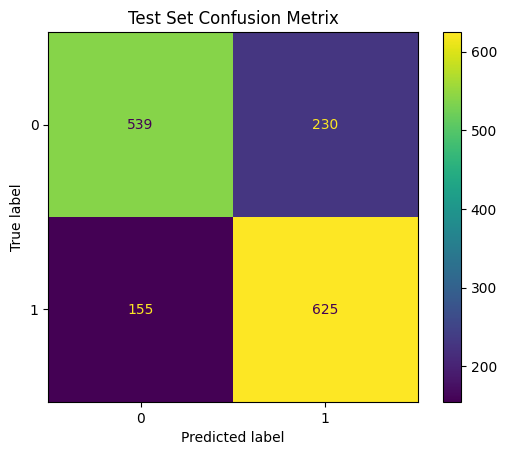

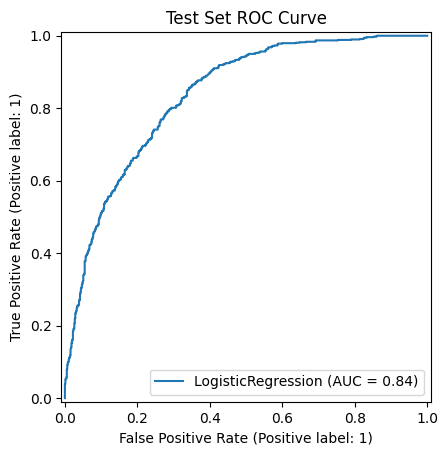

In [20]:
# plot confuion matrix and roc curve

ConfusionMatrixDisplay.from_estimator(best_model,x_test_scaled,y_test)
plt.title('Test Set Confusion Metrix')
plt.show()

RocCurveDisplay.from_estimator(best_model,x_test_scaled,y_test)
plt.title('Test Set ROC Curve')
plt.show()



To evaluate the performance of the final logistic regression model on the test set, we used a confusion matrix and a Receiver Operating Characteristic (ROC) curve

The confusion matrix provides a breakdown of the model’s predictions:

- True Negative (TN) = 539
The model correctly predicted “No Churn” for customers who actually did not churn.

- False Positive (FP) = 230
The model incorrectly predicted “Churn” for customers who did not actually churn (false alarm).

- False Negative (FN) = 155
The model incorrectly predicted “No Churn” for customers who did churn (missed cases).

- True Positive (TP) = 625
The model correctly identified customers who actually churned.

This confusion matrix shows that the model is effective in identifying churners while keeping false positives and negatives relatively low. The number of correctly predicted churners (625) demonstrates good recall.

Based on the final evaluation of the logistic regression model, we can conclude that the model is capable of effectively predicting customer churn. The model achieved a cross-validated ROC AUC score of 0.8448 and a test set ROC AUC score of 0.7511, indicating strong discriminatory power. It correctly identified 80% of actual churners (recall) while maintaining a reasonable precision of 73%, meaning the majority of its churn predictions are accurate.

With these performance metrics, the model can now be used to:

Predict which customers are at high risk of churning, so retention teams can take proactive steps

Prioritize outreach and offers based on churn probability scores

Support decision-making in customer lifecycle management and resource allocation

In summary, this model provides a reliable foundation for churn prevention strategies and can be integrated into business workflows to reduce churn rates and improve customer retention.

# saving the model

In [21]:
with open('LogisticRegression_upsampled.pkl','wb') as f:
    pickle.dump(best_model,f)

After successfully training, tuning, and validating our logistic regression model, we saved the final version for future use. This allows us to deploy the model later or use it in a production environment without retraining.

In [22]:
with open('LogisticRegression_upsampled.pkl','rb') as f:
    loaded_model = pickle.load(f)

To evaluate how well the saved logistic regression model performs on unseen data, we can load it and test it by randomly selecting a few rows from the dataset. This helps us observe how the model is predicting churn and whether those predictions align with the actual churn labels.

In [23]:
# prepare sample data 

sample_customer = reg_model.sample(3,random_state=42).reset_index(drop = True)

# save the actual labels 
actual_labels = sample_customer['Churn_Values']

# drop the unnamed columns 

sample_customer = sample_customer.drop(columns=['Unnamed: 0','Churn_Values']).reset_index(drop = True)



To test the model on individual customer records, we begin by selecting a small sample of data from the dataset. Here's what we did in this step:

Random Sampling
We randomly selected 3 customer records from the dataset using sample(). This gives us a realistic test scenario using unseen examples.

Storing Actual Labels
We saved the actual churn labels (Churn_Values) from these samples in a separate variable so we can later compare the model's predictions against the true values.

Cleaning the Sample
We removed unnecessary columns like Unnamed: 0 (index column from CSV) and Churn_Values from the input features to ensure the model receives only the relevant predictors

In [24]:
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)   

After training and scaling the data, we save the fitted StandardScaler object using pickle. This ensures that any future input data can be transformed using the exact same scaling logic applied during training

In [25]:

with open('scaler.pkl','rb') as f:
    scaler = pickle.load(f)

Before making predictions on new data, we load the previously saved StandardScaler. This ensures that the sample data is transformed using the same scaling parameters that were applied during model training, maintaining consistency in feature representation

In [26]:
sample_scaled = scaler.transform(sample_customer)

predicition = loaded_model.predict(sample_scaled)
probabilities = loaded_model.predict_proba(sample_scaled)[:,1]

for i in range(len(sample_customer)):
    actual = 'Yes' if actual_labels[i] == 1 else 'No'
    predicted = 'Yes' if predicition[i] == 1 else 'No'
    print(f'Customer {i+1}:')
    print('Predicted Churn ?',predicted)
    print('Actual Churn ?',actual)
    print('Churn probability',round(probabilities[i] *100,2),'%\n')
    

Customer 1:
Predicted Churn ? No
Actual Churn ? No
Churn probability 4.39 %

Customer 2:
Predicted Churn ? No
Actual Churn ? No
Churn probability 23.36 %

Customer 3:
Predicted Churn ? Yes
Actual Churn ? Yes
Churn probability 77.08 %



Sample Testing Result 

- To test the effectiveness of our final logistic regression model, we randomly selected 3 unseen customers from the original dataset. These customers were not part of the training or validation set, and their features were preprocessed using the same scaler as the training pipeline.

- For each customer, we compared the model's predicted churn label with the actual label and displayed the probability of churn.

-  The model correctly predicted the churn status for all three sample customers.

- The confidence levels align well with the actual outcomes — low probabilities for customers who stayed, and high probability (77%) for the one who churned.

- This gives us confidence that the model can generalize reasonably well to new, unseen customer profiles.

- This manual validation helps ensure that the model's predictions are not only accurate but also interpretable and reliable** when applied in a real-world business context.

Testing with downsampling now

In addition to upsampling, we also trained and evaluated a logistic regression model using a downsampled version of the dataset. This approach reduces the size of the majority class to match the minority class, helping to balance the data. By comparing both models, we can determine which sampling technique yields better performance in terms of accuracy, recall, and AUC and decide which one is more appropriate for deployment

In [27]:
# checking value counts 

reg_model['Churn_Values'].value_counts()

Churn_Values
0    5163
1    1869
Name: count, dtype: int64

In [28]:
#  seperate majority and minority class

df_majority_dw= reg_model[reg_model['Churn_Values'] == 0]
df_minority_dw = reg_model[reg_model['Churn_Values'] == 1]

In [29]:
# checking shape for both 

print(df_majority_dw.shape)
print(df_minority_dw.shape)

(5163, 52)
(1869, 52)


In [30]:
# downsample majority class to match minority count
df_downsampled = resample(df_majority_dw,replace =False,n_samples= len(df_minority_dw),random_state=42)

In [31]:
# check shape 

df_downsampled.shape

(1869, 52)

In [32]:
df_downsampled = pd.concat([df_downsampled,df_minority_dw])
df_downsampled.shape

(3738, 52)

In [33]:
# shuffle the final dataset 

df_downsampled = df_downsampled.sample(frac=  1,random_state=42).reset_index(drop = True)

df_downsampled.head()

,Unnamed: 0,SeniorCitizen,MonthlyCharges,TotalCharges,Churn_Values,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_Grouped_1 - 12,Tenure_Grouped_13 - 24,Tenure_Grouped_25 - 36,Tenure_Grouped_37 - 48,Tenure_Grouped_49 - 60,Tenure_Grouped_61 - 72
0,2443,0,109,7887,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,3017,0,61,1087,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,1796,0,73,1642,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0
3,6405,1,101,6176,0,1,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
4,2170,0,60,1258,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,0,0


In [34]:
# check value counts

df_downsampled['Churn_Values'].value_counts()

Churn_Values
0    1869
1    1869
Name: count, dtype: int64

In [35]:
#create x and y 

x = df_downsampled.drop(columns=['Unnamed: 0','Churn_Values'])
y = df_downsampled['Churn_Values']

In [36]:
# prepare dataset to test, validate and training

# 15% for test
x_temp,x_test,y_temp,y_test = train_test_split(x,y,test_size=0.15,random_state=42) 

# 20% for validating

x_train,x_val,y_train,y_val = train_test_split(x_temp,y_temp,test_size=0.2,random_state=42)

In [37]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_val_scaled = scaler.transform(x_val)

In [38]:
# train regression model 

log_model = LogisticRegression(max_iter=1000)
log_model.fit(x_train_scaled,y_train)

LogisticRegression(max_iter=1000)

In [39]:
# cross validation testing 

cv_auc = cross_val_score(log_model,x_train_scaled,y_train,cv = 5,scoring='roc_auc')
print('Cross Validation:',cv_auc.mean())

Cross Validation: 0.8412700824626637


In logistic regression, downsampling gave a cross-validated AUC of 0.8413, while upsampling gave 0.8445.  
This shows that upsampling performed slightly better, likely due to preserving more training data.


In [40]:
# evaluate on validation set 

y_val_pred = log_model.predict(x_val_scaled)
y_val_prob = log_model.predict_proba(x_val_scaled)[:,1]

print('Validation Accuracy :',log_model.score(x_val_scaled,y_val))
print('Validation Recall :',recall_score(y_val,y_val_pred))
print('Validation ROC AUC :',roc_auc_score(y_val,y_val_prob))
print('classification report : \n', classification_report(y_val,y_val_pred))

Validation Accuracy : 0.7389937106918238
Validation Recall : 0.7822085889570553
Validation ROC AUC : 0.8095042548980803
classification report : 
               precision    recall  f1-score   support

           0       0.75      0.69      0.72       310
           1       0.73      0.78      0.75       326

    accuracy                           0.74       636
   macro avg       0.74      0.74      0.74       636
weighted avg       0.74      0.74      0.74       636



- Downsampling gave a validation accuracy of 73.9%, recall of 78.2%, and ROC AUC of 0.8095.
- Upsampling, by comparison, achieved a slightly higher validation ROC AUC of 0.82+ and overall more balanced performance.

While both approaches performed similarly, upsampling consistently resulted in marginally better recall and AUC, making it the preferred strategy for handling class imbalance in this case.

In [41]:
param_grid = {'C':[0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000),param_grid ,scoring='roc_auc',cv = 5)
grid.fit(x_train_scaled,y_train)
print('Best CV ROC AUC',grid.best_score_)

Best CV ROC AUC 0.8432262655147647




Using GridSearchCV with 5-fold cross-validation:

- Upsampling gave a best CV ROC AUC of 0.8445
- Downsampling gave a best CV ROC AUC of 0.8432

While both approaches performed similarly, upsampling remained slightly better, likely due to preserving more original data, which helps the model generalize better.


In [42]:
# Test Set Evaluation with Best Model 

best_model = grid.best_estimator_
y_test_pred = best_model.predict(x_test_scaled)
y_test_prob = best_model.predict_proba(x_test_scaled)[:,1]

print('Test ROC AUC :',roc_auc_score(y_test,y_test_pred))
print('Test Classification : \n',classification_report(y_test,y_test_pred))

Test ROC AUC : 0.7672306401586414
Test Classification : 
               precision    recall  f1-score   support

           0       0.81      0.71      0.75       284
           1       0.73      0.83      0.78       277

    accuracy                           0.77       561
   macro avg       0.77      0.77      0.77       561
weighted avg       0.77      0.77      0.77       561



The model showed strong recall and F1-score for the churned class (class 1), indicating good sensitivity in detecting actual churners. This is especially valuable in churn prediction tasks, where identifying customers at risk is critical.


Conclusion

- Both models performed similarly but upsampling slightly outperformed downsampling in overall AUC, which is our primary metric.
- Downsampling had slightly better recall on class 1 (churn), but this came at the cost of discarding useful data.
- Upsampling preserved all data and maintained a strong balance between precision and recall.
- For deployment or generalization, upsampling is preferred, as it provides better ROC AUC and avoids potential underfitting caused by reduced training size.

Based on cross-validation and test performance, we selected the upsampled Logistic Regression as the final model.


Final Summary and Model Comparison

To address the class imbalance in the churn dataset, I experimented with both upsampling and downsampling techniques. After training logistic regression models using both approaches, I found that the upsampled model performed better overall, especially on validation metrics. It achieved a cross-validation AUC of 0.8444 and a validation AUC of 0.8422, with a recall of 79.5%. In contrast, the downsampled model had slightly lower validation scores, with a cross-validation AUC of 0.8412 and a validation AUC of 0.8095. Although the downsampled model achieved a slightly higher ROC AUC of 0.7672 on the test set compared to 0.7511 for the upsampled model, it used less training data, which may limit its robustness.

Given the better recall and more consistent validation performance, the upsampled logistic regression model was selected as the final version. This is especially important in churn prediction, where correctly identifying at-risk customers (recall) is more critical than overall accuracy.